## MCMC from file

Load hdf5 file from Data Fitting.ipynb that includes experiment meta data and time vs position data for MCMC analysis.

In [1]:
# import packages
from __future__ import print_function
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
import pandas as pd
import sys
sys.path.insert(0,"C:/path/to/emcee-master")
import emcee as mc
import corner

sys.path.insert(0,"../Model")

from trig_fund import *
from dambreak import dambreak
from syrup_prop import Visc

# import packages for google drive
import io as IO
import pickle
import os
import os.path
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from googleapiclient.http import MediaFileUpload
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2 import service_account

# set default plotting parameters
plt.rc('font', size=22) #set default font size to 22 (from 10)
plt.rcParams['lines.linewidth'] = 4.0 #set default line width to 2.0 (from 1.0)


## Flow of a Herschel-Bulkley fluid on an inclined plane following derivation from Liu & Mei (1989), Balmforth et al. (2007):

$ \frac{\partial h}{\partial t} = -\left( \frac{\rho g}{K} \right)^{1/n} \frac{\partial}{\partial x} \left[ \frac{n \left| \sin{\theta} - \cos{\theta} \frac{\partial h}{\partial x} \right|^{1/n-1} Y^{1+1/n}}{(n+1)(2n+1)} \left[(1+2n)h-nY \right] \left( \sin{\theta} -  \cos{\theta} \frac{\partial h}{\partial x} \right) \right] $

$ Y = h - \frac{\tau_y}{\rho g |\sin{\theta} -\cos{\theta} \frac{\partial h}{\partial x}|} $

For full derivation see included PDF "Viscoplastic Flow Derivation".

In [0]:
# import from google drive

SCOPES = ['https://www.googleapis.com/auth/drive']

"""Shows basic usage of the Drive v3 API.
Prints the names and ids of the first 10 files the user has access to.
"""
creds = None
# The file token.pickle stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
if os.path.exists('token_JB.pickle'):
    with open('token_JB.pickle', 'rb') as token:
        creds = pickle.load(token)
# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            'client_secret.json', SCOPES)
        creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open('token_JB.pickle', 'wb') as token:
        pickle.dump(creds, token)
        
service = build('drive', 'v3', credentials=creds)

# Call the Drive v3 API
results = service.files().list(q = "name contains 'MVI_0724.h5'", # change just this line to the h5 filename
    pageSize=5, fields="nextPageToken, files(id, name)").execute()
items = results.get('files', [])

if not items:
    print('No files found.')

fileid = items[0]['id']
filename =  items[0]['name']
filepath = os.getcwd()
request = service.files().get_media(fileId=fileid)
fh = IO.BytesIO()
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))

print('Saving local copy')
with IO.open(filepath + '/' + filename, 'wb') as f:
    fh.seek(0)
    f.write(fh.read())
print('Done! Loaded ' + filename)

Download 100%.
Saving local copy
Done! Loaded MVI_0726.h5


In [52]:
filename = 'C:/path/to/file/file.h5'
samples = pd.read_hdf(filename, key='s')
samples.head()

,K,tauy,n,theta
0,2.198265,0.15782,1.440717,-0.09339
1,2.198265,0.15782,1.440717,-0.09339
2,2.198265,0.15782,1.440717,-0.09339
3,2.198265,0.15782,1.440717,-0.09339
4,2.198265,0.15782,1.440717,-0.09339


In [54]:
meta = pd.read_hdf(filename, key='meta')
meta

,H,K_fluid,L,Particle,Phi_gas,Phi_solid,Rho,Slope,Temp,Title,K_post,K_r,tauy_post,n_post,K_std,tauy_std,n_std,theta_post,theta_std
0,0.033,4.553703,0.2,No,0,0,1.395,0,28.1,MVI_0694,4.363893,0.958317,0.075694,1.057363,0.695965,0.444813,0.142841,0.205376,0.203245


       H   K_fluid    L Particle  Phi_gas  Phi_solid    Rho  Slope  Temp  \
0  0.033  4.553703  0.2       No        0          0  1.395      0  28.1   

      Title    K_post       K_r  tauy_post    n_post     K_std  tauy_std  \
0  MVI_0694  4.363893  0.958317   0.075694  1.057363  0.695965  0.444813   

      n_std  theta_post  theta_std  
0  0.142841    0.205376   0.203245  
       Time     X_pos
0  0.005300  0.002182
1  0.038667  0.004000
2  0.072033  0.007273
3  0.105400  0.012727
4  0.138767  0.018182


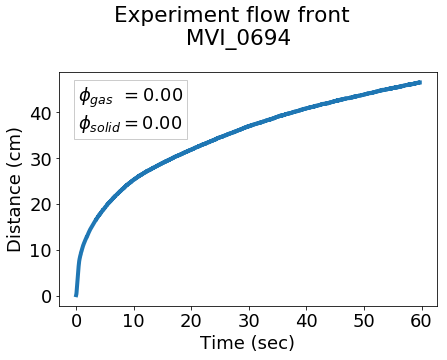

In [56]:
meta = pd.read_hdf(filename, key='meta')
print(meta)
H = meta.H[0]
L = meta.L[0]
K_fluid = meta.K_fluid[0]
rho = meta.Rho[0]*1000
theta = meta.Slope[0]
T = meta.Temp[0]
phi_gas = meta.Phi_gas[0]
phi_solid = meta.Phi_solid[0]
title_str = meta.Title[0]

try:
    meta.K_post
    K_init = meta.K_post[0]
    tauy_init = meta.tauy_post[0]
    n_init = meta.n_post[0]
except AttributeError:
    K_init = meta.K_guess[0]
    tauy_init = meta.tauy_guess[0]
    n_init = meta.n_guess[0]

dat = pd.read_hdf(filename, key='df')
print(dat.head())

t0 = 0 # Time of dam release [sec]
tloc = int(t0/(dat.Time[1] - dat.Time[0]))
t_pos = dat.Time.iloc[tloc:] - dat.Time.iloc[tloc]
x_pos = dat.X_pos.iloc[tloc:]

# plot scaled front advance
fig,ax = plt.subplots(figsize=(7,5))
ax.plot(t_pos, x_pos*100)
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Distance (cm)')

textstr = '\n'.join((
    r'$\phi_{gas} \: \: =%.2f$' % (phi_gas, ),
    r'$\phi_{solid}=%.2f$' % (phi_solid, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle=None, facecolor='w', alpha=0.2)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)


fig.subplots_adjust(bottom=0.15, top=0.8, left=0.15)
fig.suptitle('Experiment flow front \n ' + title_str)
fig.savefig('Flow_front_' + title_str + '.pdf')

#file_metadata = {'name': 'Flow_front_' + title_str + '.pdf', 'parents': ['1zM6oSJugXEWYybwzwO0YVvfAShTHpKbp']}
#media = MediaFileUpload('Flow_front_' + title_str + '.pdf')
#file = service.files().create(body=file_metadata,
#                                    media_body=media).execute()
#media = None

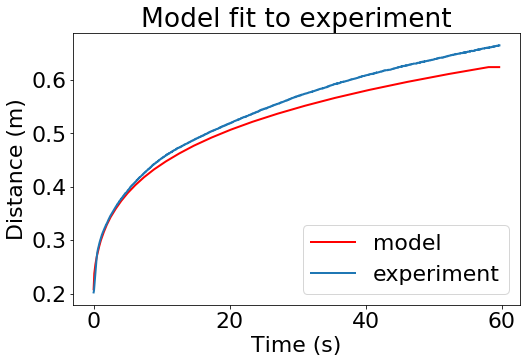

In [59]:
plt.rc('font', size=22) #set default font size to 22 (from 10)
plt.rcParams['lines.linewidth'] = 2.0 #set default line width to 2.0 (from 1.0)

# Plot most probable model with data
x_grid = np.linspace(0,1.2*np.max(x_pos)+L,52)
dx = x_grid[1] - x_grid[0]
h0 = np.zeros_like(x_grid)
h0[x_grid<0.2] = H

res = 50
h, t = dambreak(x_grid, h0, 0, rho, K_init, tauy_init, n_init, 9.81, t_pos.iloc[-1], res*t_pos.size)
X = np.zeros_like(t_pos)
t_match = np.zeros_like(t_pos)

threshold = 0.0001
for j in np.arange(t_pos.size):
    X[j] = x_grid[np.max(np.nonzero(h[j*res,:]>threshold)) + 1] # find node with h>threshold
    t_match[j] = t[j*res]
    ind = np.nonzero(X[1:] - X[:-1])[0]
    model = np.interp(t_match,t_match[ind],X[ind])

# Plot front advance
fig,ax = plt.subplots(figsize=(8,5))

ax.plot(t_match,model,'r-',label='model');
ax.plot(t_pos,x_pos+L,label='experiment')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance (m)')
ax.set_title('Model fit to experiment')
ax.legend();

In [ ]:
# Save guess

meta['K_guess'] = K_guess
meta['tauy_guess'] = tauy_guess
meta['n_guess'] = n_guess

meta.to_hdf(title_str + '.h5', key='meta', mode='a')
meta.to_hdf('Experiments_summary.h5', key=title_str, mode='a')

file_metadata = {'name': title_str + '.h5', 'parents': ['1zM6oSJugXEWYybwzwO0YVvfAShTHpKbp']}
media = MediaFileUpload(title_str + '.h5')
#file = service.files().create(body=file_metadata,
                                    #media_body=media).execute()

file_metadata = {'name': 'Experiments_summary.h5', 'parents': ['1zM6oSJugXEWYybwzwO0YVvfAShTHpKbp']}
media = MediaFileUpload('Experiments_summary.h5')
#file = service.files().create(body=file_metadata,
                                    #media_body=media).execute()

In [ ]:
# Setup model for MCMC

def lnlike(mu, x, y, yerr):
    K, tauy, n, theta = mu
    h, t = dambreak(x_grid, h0, theta, rho, K, tauy, n, 9.81, t_pos.iloc[-1], 50*t_pos.size)
    X = np.zeros_like(t_pos)
    t_match = np.zeros_like(t_pos)

    threshold = 0.0001
    for j in np.arange(t_pos.shape[0]):
        X[j] = x_grid[np.max(np.nonzero(h[j*50,:]>threshold)) + 1] # find node with h>threshold
        t_match[j] = t[j*50]
    ind = np.nonzero(X[1:] - X[:-1])[0]
    model = np.interp(t_match,t_match[ind],X[ind])
    
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*yerr**2)))

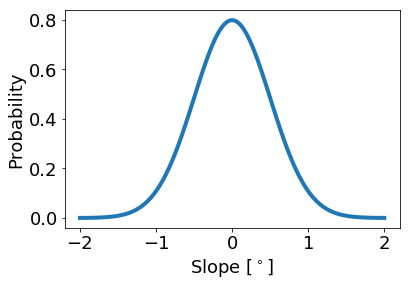

In [55]:
# Initial guesses for MCMC
K_min = 0.5*K_init
K_max = 1.5*K_init

tauy_init += 0.1
tauy_min = 0
tauy_max = 50

n_min = 0.7
n_max = 2.5

theta_sig = 0.5
theta_range = np.linspace(-2,2,100)
def p_theta(theta):
    return 1/np.sqrt(2*np.pi*theta_sig**2)*np.exp(-theta**2/(2*theta_sig**2))

fig,ax = plt.subplots()
ax.plot(theta_range,p_theta(theta_range))
ax.set_ylabel('Probability')
ax.set_xlabel('Slope [$^\circ$]')

init_pos = [K_init, tauy_init, n_init, 0]

# load data to MCMC
x = t_pos
y = x_pos + L

# Define model resolution for MCMC
x_grid = np.linspace(0,0.75,52)
dx = x[1] - x[0]
yerr = 2*dx
h0 = np.zeros_like(x_grid)
h0[x_grid<0.2] = H

In [0]:
# Uniform prior distribution
def lnprior(mu):
    K, tauy, n, theta = mu
    if K_min < K < K_max and tauy_min < tauy < tauy_max and n_min < n < n_max:
        return np.log(p_theta(theta))
    return -np.inf

def lnprob(mu, x, y, yerr):
    lp = lnprior(mu)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(mu, x, y, yerr)

In [0]:
# Create walkers
ndim, nwalkers = 4, 16
mu_pos = [init_pos + [K_init/10, tauy_init/10, n_init/20, theta_sig]*np.random.randn(ndim) for i in range(nwalkers)]

In [0]:
# Run MCMC 
steps = 500
sampler = mc.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(mu_pos, steps, progress=True);

  0%|                                                   | 0/10 [00:00<?, ?it/s]


RuntimeError: It is unadvisable to use a red-blue move with fewer walkers than twice the number of dimensions.

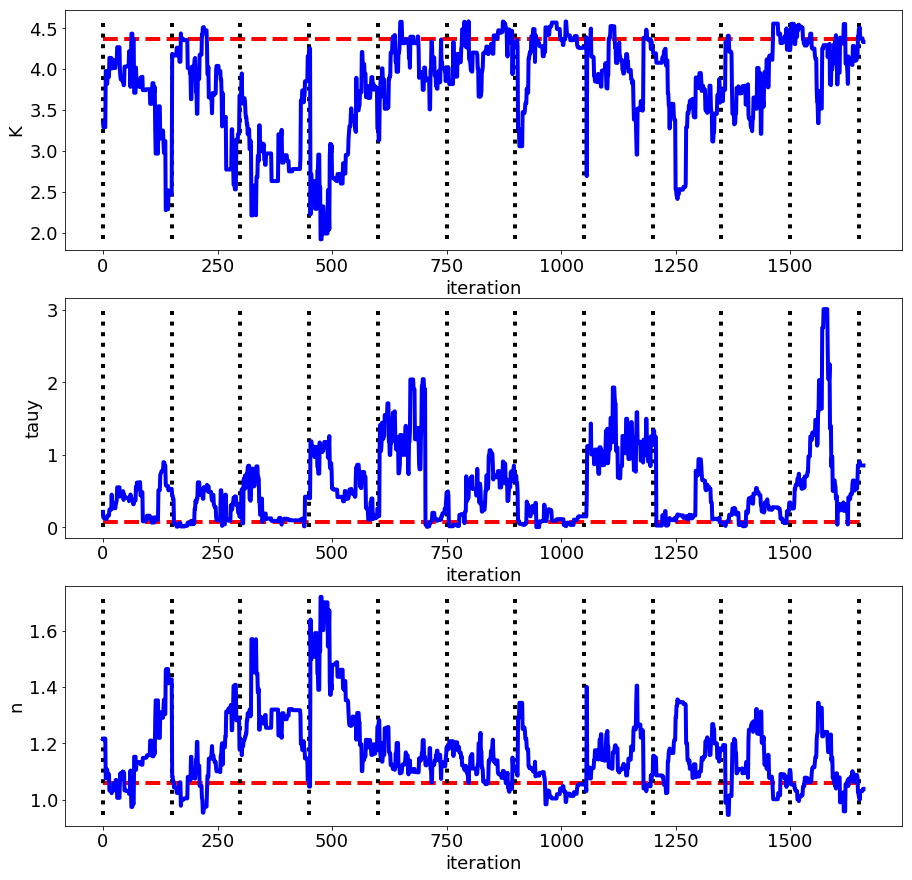

In [61]:
# inspect runs
#s = 150
#samples_full = sampler.chain[:, s:, :].reshape((-1, ndim))

samples_full = samples.values
nwalkers = 12
steps = 500
s = 350

subset = np.zeros((0,4))

for walker in np.arange(nwalkers):
    subset = np.append(subset,samples_full[(walker*steps + s):((walker + 1)*steps + 1)],axis=0)

samples_full = subset
    

fig,ax = plt.subplots(nrows=3, figsize=(15,15))
ax[0].plot(samples_full[:,0],'b-')
ax[0].hlines(K_post, 0, samples_full.shape[0],colors='r',linestyles='dashed')
ax[0].vlines(np.arange(nwalkers)*(steps-s),np.min(samples_full[:,0]),np.max(samples_full[:,0]),colors='k',linestyles='dotted')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('K')
ax[1].plot(samples_full[:,1],'b-')
ax[1].hlines(tauy_post, 0, samples_full.shape[0],colors='r',linestyles='dashed')
ax[1].vlines(np.arange(nwalkers)*(steps-s),np.min(samples_full[:,1]),np.max(samples_full[:,1]),colors='k',linestyles='dotted')
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('tauy')
ax[2].plot(samples_full[:,2],'b-')
ax[2].hlines(n_post, 0, samples_full.shape[0],colors='r',linestyles='dashed')
ax[2].vlines(np.arange(nwalkers)*(steps-s),np.min(samples_full[:,2]),np.max(samples_full[:,2]),colors='k',linestyles='dotted')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('n');

K = 4.3+0.2-1.7
tau_y = 0.08+1.33-0.05
n = 1.08+0.35-0.08
theta = 0.24+0.37-0.26


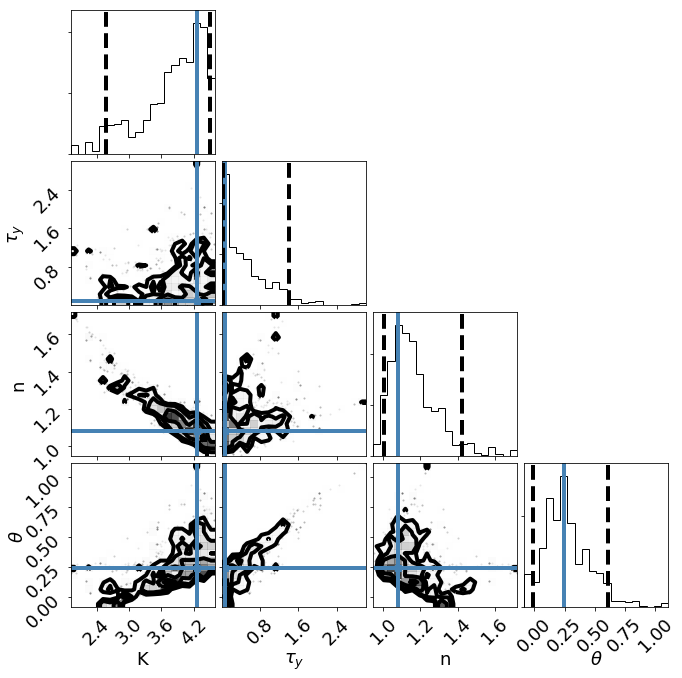

In [89]:
# Inspect MCMC results
#ignore initial samples

K_fit = samples_full[:,0]; tauy_fit = samples_full[:,1]; n_fit = samples_full[:,2]; theta_fit = samples_full[:,3]

# Find mode of each posterior distribution
N, bin_edges = np.histogram(K_fit, bins=20)
K_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 
N, bin_edges = np.histogram(tauy_fit, bins=20)
tauy_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 
N, bin_edges = np.histogram(n_fit, bins=20)
n_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 
N, bin_edges = np.histogram(theta_fit, bins=20)
theta_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 

# Find quantiles
K_Q05 = np.quantile(K_fit, .05)
K_Q95 = np.quantile(K_fit, .95)

tauy_Q05 = np.quantile(tauy_fit, .05)
tauy_Q95 = np.quantile(tauy_fit, .95)

n_Q05 = np.quantile(n_fit, .05)
n_Q95 = np.quantile(n_fit, .95)

theta_Q05 = np.quantile(theta_fit, .05)
theta_Q95 = np.quantile(theta_fit, .95)

# set default plotting parameters
plt.rc('font', size=18) #set default font size to 22 (from 10)
plt.rcParams['lines.linewidth'] = 4.0 #set default line width to 2.0 (from 1.0)

# plot
fig = corner.corner(samples_full, labels=["K", r"$\tau_y$", "n", r"$\theta$"],
                  truths=[K_post, tauy_post, n_post, theta_post], quantiles=[0.05, 0.95])

print('K = ' + np.array2string(K_post,precision=1) + 
         '+' + np.array2string(K_Q95 - K_post,precision=1) + 
         '-' + np.array2string(K_post - K_Q05,precision=1) + '\n'
     'tau_y = ' + np.array2string(tauy_post,precision=2) + 
            '+' + np.array2string(tauy_Q95 - tauy_post,precision=2) + 
            '-' + np.array2string(tauy_post - tauy_Q05,precision=2) + '\n'
     'n = ' + np.array2string(n_post,precision=2) + 
         '+' + np.array2string(n_Q95 - n_post,precision=2) + 
         '-' + np.array2string(n_post - n_Q05,precision=2) + '\n'
     'theta = ' + np.array2string(theta_post,precision=2) + 
         '+' + np.array2string(theta_Q95 - theta_post,precision=2) + 
         '-' + np.array2string(theta_post - theta_Q05,precision=2))

In [87]:
Q2 = np.quantile(K_fit, .50)
Q1 = np.quantile(K_fit, .25)
Q3 = np.quantile(K_fit, .75)

print('K = ' + np.array2string(Q2,precision=2) + 
         '+' + np.array2string(Q3 - Q2,precision=2) + 
         '-' + np.array2string(Q2 - Q1))

K = 3.95+0.32-0.45094839


3.115956554148204

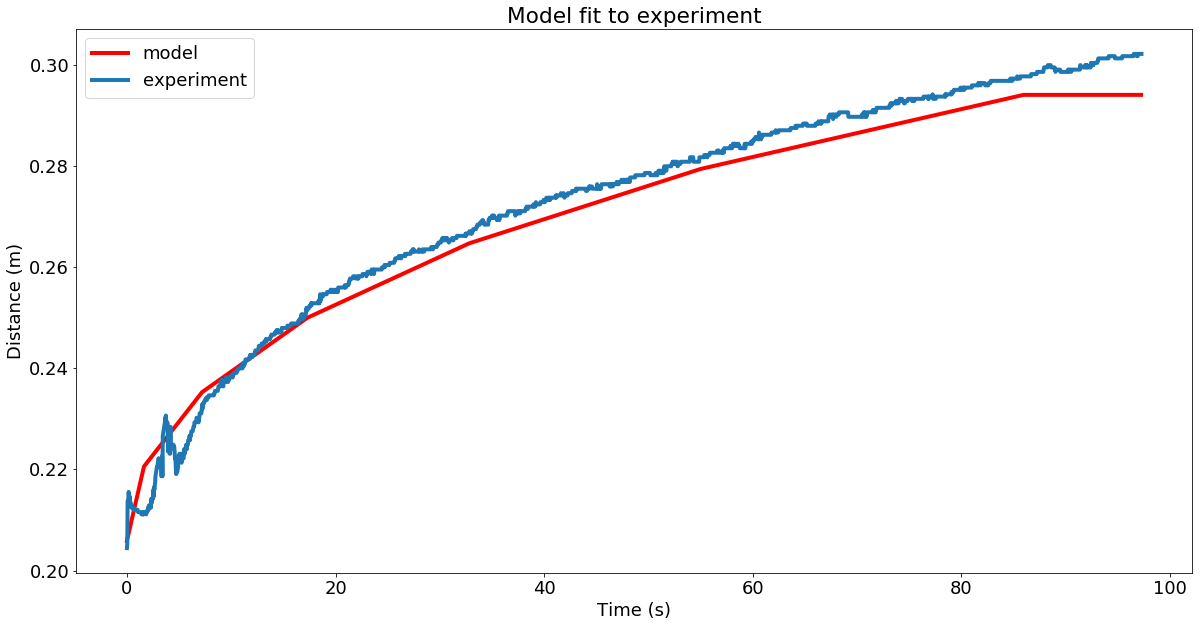

In [50]:
# Plot most probable model with data
x_grid = np.linspace(0,0.75,52)
dx = x_grid[1] - x_grid[0]
h0 = np.zeros_like(x_grid)
h0[x_grid<0.2] = H
h, t = dambreak(x_grid, h0, theta, rho, 150, tauy_post, n_post, 9.81, t_pos.iloc[-1], 25*t_pos.size)
X = np.zeros_like(t_pos)
t_match = np.zeros_like(t_pos)

threshold = 0.0001
for j in np.arange(t_pos.size):
    X[j] = x_grid[np.max(np.nonzero(h[j*25,:]>threshold)) + 1] # find node with h>threshold
    t_match[j] = t[j*25]
    ind = np.nonzero(X[1:] - X[:-1])[0]
    model = np.interp(t_match,t_match[ind],X[ind])

# Plot front advance
fig,ax = plt.subplots(figsize=(20,10))

ax.plot(t_match,model,'r-',label='model');
ax.plot(t_pos,x_pos+L,label='experiment')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance (m)')
ax.set_title('Model fit to experiment')
ax.legend();

In [0]:
# Save posterior distribution

s = 0 # ignore initial samples
samples = sampler.chain[:, s:, :].reshape((-1, ndim))
K_fit = samples[:,0]; tauy_fit = samples[:,1]; n_fit = samples[:,2]


meta['K_post'] = K_post
meta['K_r'] = K_post/K_fluid
meta['tauy_post'] = tauy_post
meta['n_post'] = n_post
meta['K_std'] = K_std
meta['tauy_std'] = tauy_std
meta['n_std'] = n_std

meta.to_hdf(title_str + '.h5', key='meta', mode='a')

samples = pd.DataFrame({'K':K_fit, 'tauy':tauy_fit, 'n':n_fit})
samples.to_hdf(title_str + '.h5', key='s', mode='a')

file_metadata = {'name': title_str + '.h5', 'parents': ['1zM6oSJugXEWYybwzwO0YVvfAShTHpKbp']}
media = MediaFileUpload(title_str + '.h5')
file = service.files().create(body=file_metadata,
                                    media_body=media).execute()

meta.to_hdf('Experiments_summary.h5', key=title_str, mode='a')
file_metadata = {'name': 'Experiments_summary.h5', 'parents': ['1zM6oSJugXEWYybwzwO0YVvfAShTHpKbp']}
media = MediaFileUpload('Experiments_summary.h5')
file = service.files().create(body=file_metadata,
                                    media_body=media).execute()

ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

In [0]:
# remove local files after upload
media = None
os.remove(filename)